In [4]:
import os
from random import random, sample
import argparse
from tqdm import tqdm
import numpy as np
from PIL import Image, ImageDraw
from imutils import video
import cv2
import dlib
import face_recognition


import matplotlib.pyplot as plt

parser = argparse.ArgumentParser()

# input, output
parser.add_argument("--input_dir", help="where to get input images")
parser.add_argument("--output_dir", help="where to put output images")
parser.add_argument("--max_num_images", type=int, help="maximum number of images to take (omit to use all)", default=None)
parser.add_argument("--shuffle", action="store_true", help="shuffle image")

#args = parser.parse_args()

#args.num_augment, args.w, args.h, args.frac, args.frac_vary, args.max_ang, args.max_stretch, args.centered
# no aug
# n=1, w2, h2, frac=1.0, frac_vary=0.0, max_ang=0, max_stretch=0, centered=True

#min_w, min_h = 512

allowable_actions = ['none', 'quantize', 'trace', 'hed', 'segment', 'simplify', 'face']





In [87]:

def cv2pil(cv2_img):
    if len(cv2_img.shape) == 2 or cv2_img.shape[2]==1:
        cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_GRAY2RGB)
    else:
        cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(cv2_img.astype('uint8'))
    return pil_img

def pil2cv(pil_img):
    pil_img = pil_img.convert('RGB') 
    cv2_img = np.array(pil_img) 
    cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_RGB2BGR)
    cv2_img = cv2_img[:, :, ::-1].copy()
    return cv2_img
    
    
    

def posterize(im, n):
    indices = np.arange(0,256)   # List of all colors 
    divider = np.linspace(0,255,n+1)[1] # we get a divider
    quantiz = np.int0(np.linspace(0,255,n)) # we get quantization colors
    color_levels = np.clip(np.int0(indices/divider),0,n-1) # color levels 0,1,2..
    palette = quantiz[color_levels] # Creating the palette
    im2 = palette[im]  # Applying palette on image
    im2 = cv2.convertScaleAbs(im2) # Converting image back to uint8
    return im2

def canny(im1):
    im1 = pil2cv(im1)
    im2 = cv2.GaussianBlur(im1, (5, 5), 0)
    im2 = cv2.Canny(im2, 100, 150)
    im2 = cv2.cvtColor(im2, cv2.COLOR_GRAY2RGB)
    im2 = cv2pil(im2)
    return im2

def image2colorlabels(img, colors):
    h, w = img.height, img.width
    pixels = np.array(list(img.getdata()))
    dists = np.array([np.sum(np.abs(pixels-c), axis=1) for c in colors])
    classes = np.argmin(dists, axis=0)
    
def colorize_labels(img, colors):
    h, w = img.height, img.width
    classes = image2colorlabels(img, colors)
    img = Image.fromarray(np.uint8(classes.reshape((h, w, 3))))
    return img

def quantize_colors(img, colors):
    h, w = img.height, img.width
    classes = image2colorlabels(img, colors)
    pixels_clr = np.array([colors[p] for p in classes]).reshape((h, w, 3))
    img = Image.fromarray(np.uint8(pixels_clr))
    return img

def segment(img):
    img = pil2cv(img)
    h, w = img.shape[0:2]
    img = cv2.bilateralFilter(img, 9, 100, 100)
    scale = int(h * w / 1000)
    segments = felzenszwalb(img, scale=scale, sigma=0.5, min_size=150)
    out_image = np.zeros((h, w, 3))
    num_segments = len(np.unique(segments))
    for s in tqdm(range(num_segments)):
        label_map = segments==s
        label_map3 = np.dstack([label_map] * 3)
        masked_img = np.multiply(label_map3, img)
        #avg_color = np.sum(np.sum(masked_img, axis=0), axis=0) / np.count_nonzero(label_map)  # maybe median is better
        nonzeros = [ masked_img[:, :, c].reshape((h * w)) for c in range(3) ]
        median_color = [ np.median(np.take(nonzeros[c], nonzeros[c].nonzero())) for c in range(3) ]
        smooth_segment = (label_map3 * median_color).astype('uint8')
        out_image += smooth_segment
    out_image = Image.fromarray(out_image.astype('uint8'))
    return out_image

def trace(img):
    img = pil2cv(img)
    im2 = cv2.GaussianBlur(img, (5, 5), 0)
    im3 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)
    ret, im4 = cv2.threshold(im3, 127, 255, 0)
    ret, img = cv2.threshold(im3, 255, 255, 0)
    im5, contours, hierarchy = cv2.findContours(im4, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [ c for c in contours if cv2.arcLength(c, True) > 8 ] #and cv2.contourArea(c) > 10]
    for contour in contours:
        cv2.drawContours(img, [contour], 0, (255), 2)
    img = cv2pil(img)
    return img


def simplify(img, hed_model_path):
    w, h = img.width, img.height
    size_thresh = 0.001 * w * h
    img = pil2cv(img)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = run_hed(cv2pil(img), hed_model_path)
    ret, img = cv2.threshold(pil2cv(img), 50, 255, 0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = remove_small_objects(img.astype('bool'), size_thresh)
    img = 255 * skeletonize(img).astype('uint8')
    img = cv2pil(img)
    return img
    
    
def upsample(img, w2, h2):
    h1, w1 = img.height, img.width
    r = max(float(w2)/w1, float(h2)/h1)
    img = img.resize((int(r*w1), int(r*h1)), resample=Image.BICUBIC)
    return img


    
def crop_rot_resize(img, frac, w2, h2, ang, stretch, centered):
    if img.height < h2 or img.width < w2:
        img = upsample(img, w2, h2)
    
    if stretch != 0:
        v = random() < 0.5
        h = 1.0 if not v else (1.0 + stretch)
        w = 1.0 if v else (1.0 + stretch)
        img = img.resize((int(img.width * w), int(img.height * h)), resample=Image.BICUBIC)
        
    if ang > 0:
        img = img.rotate(ang, resample=Image.BICUBIC, expand=False)
   
    ar = float(w2 / h2)
    h1, w1 = img.height, img.width

    if float(w1) / h1 > ar:
        h1_crop = max(h2, h1 * frac)
        w1_crop = h1_crop * ar
    else:
        w1_crop = max(w2, w1 * frac)
        h1_crop = w1_crop / ar

    #xr, yr = 0.275 + 0.45*random(), 0.275 + 0.45*random()
    xr, yr = random(), random()
    x_crop, y_crop = (w1 - w1_crop - 1) * xr, (h1 - h1_crop - 1) * yr
    h1_crop, w1_crop, y_crop, x_crop = int(h1_crop), int(w1_crop), int(y_crop), int(x_crop)
    img_crop = img.crop((x_crop, y_crop, x_crop+w1_crop, y_crop+h1_crop))
    img_resize = img_crop.resize((w2, h2))
    
    return img_resize


def augmentation(img):#, args):
    #n, w2, h2, frac, frac_vary, max_ang, max_stretch, centered = args.num_augment, args.w, args.h, args.frac, args.frac_vary, args.max_ang, args.max_stretch, args.centered
    n, w2, h2, frac, frac_vary, max_ang, max_stretch, centered = 1, 256, 256, 0.9, 0.05, 0, 0, False
    imgs = []
    for n in range(n):
        ang = max_ang * (-1.0 + 2.0 * random())
        frac_amt = frac + frac_vary * (-1.0 + 2.0 * random())
        stretch = max_stretch * (-1.0 + 2.0 * random())
        newimg = crop_rot_resize(img, frac_amt, w2, h2, ang, stretch, centered)
        imgs.append(newimg)
    return imgs






In [96]:

def get_face(img):
    img = np.array(img)
    locations = face_recognition.face_locations(img, model="cnn")
    encodings = face_recognition.face_encodings(img, locations)
    landmarks = face_recognition.face_landmarks(img, locations)
    distances = [ face_recognition.face_distance([target_encodings], encoding) for encoding in encodings ]
    idx_closest = distances.index(min(distances))
    closest_face, closest_landmarks = locations[idx_closest], landmarks[idx_closest]
    top, right, bottom, left = face
    x, y, w, h = left, top, right-left, bottom-top
    return x, y, w, h, closest_landmarks


def draw_landmarks(img_, landmarks, color, width):
    img = Image.fromarray(np.copy(img_))
    d = ImageDraw.Draw(img, 'RGBA')

    # Make the eyebrows into a nightmare
    #whole_face = landmarks['chin'] + reversed(landmarks['left_eyebrow']) + reversed(landmarks['right_eyebrow'])
    d.line(landmarks['left_eyebrow'], fill=color, width=width)
    d.line(landmarks['right_eyebrow'], fill=color, width=width)
    d.line(landmarks['left_eye'], fill=color, width=width)
    d.line(landmarks['right_eye'], fill=color, width=width)
    d.line(landmarks['top_lip'], fill=color, width=width)
    d.line(landmarks['bottom_lip'], fill=color, width=width)
    d.line(landmarks['nose_bridge'], fill=color, width=width)
    d.line(landmarks['nose_tip'], fill=color, width=width)
    d.line(landmarks['chin'], fill=color, width=width)
    #d.line(whole_face, fill=color, width=width)
    
    return img


 20%|██        | 1/5 [00:00<00:00,  7.85it/s]

0 0 0 5
1 0 1 5
2 0 2 5


100%|██████████| 5/5 [00:00<00:00,  9.53it/s]

3 0 3 5
4 0 4 5


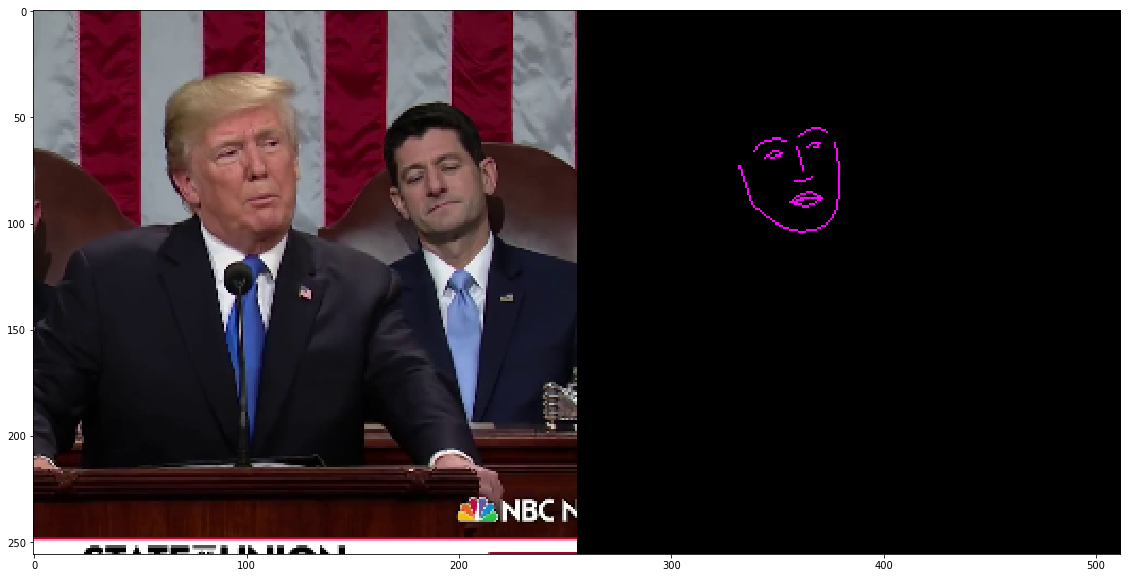

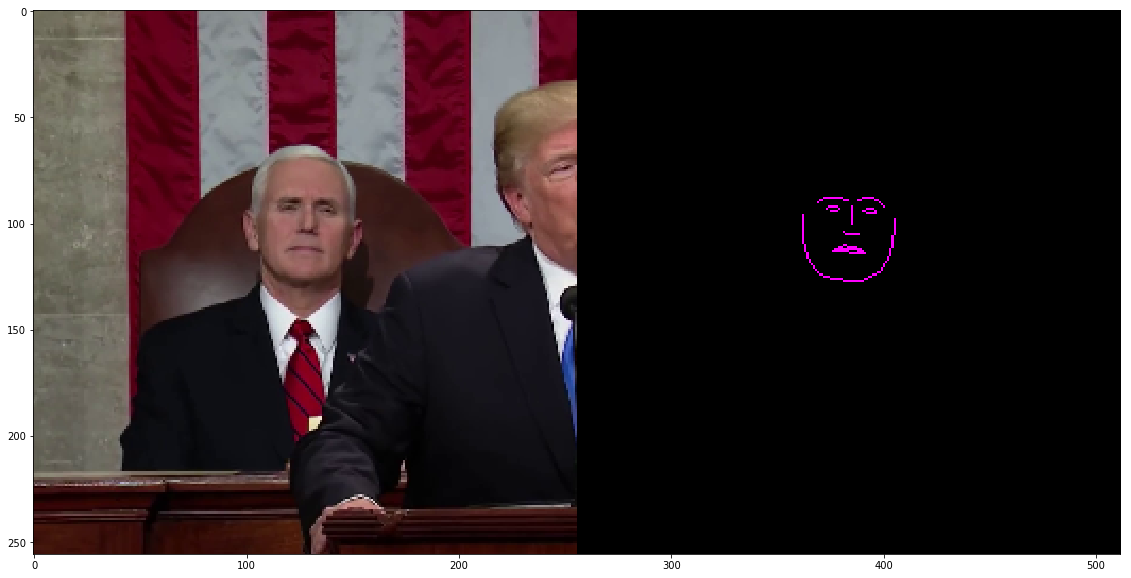

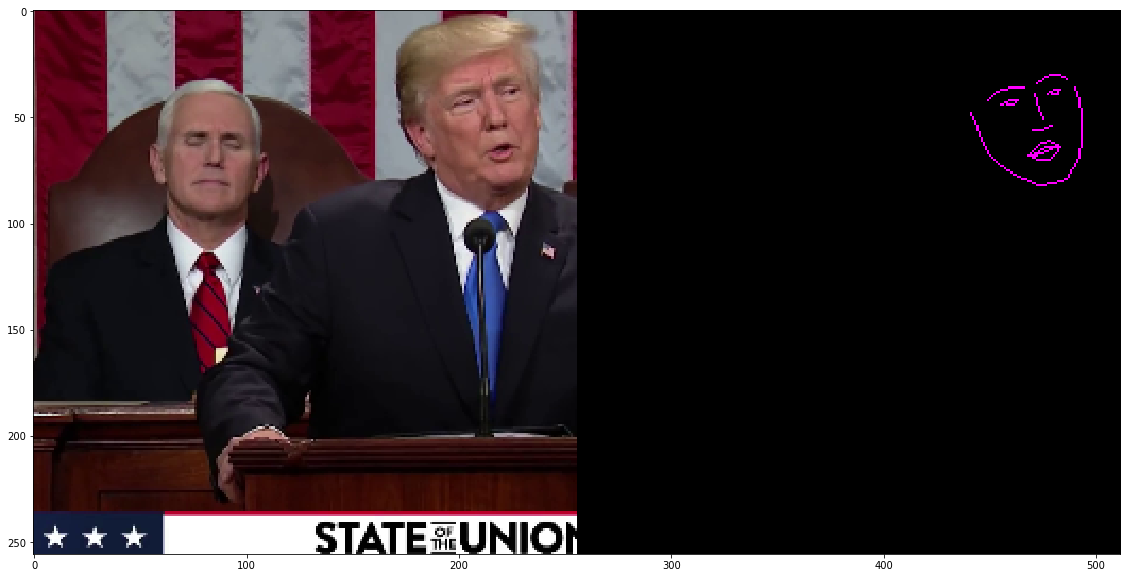

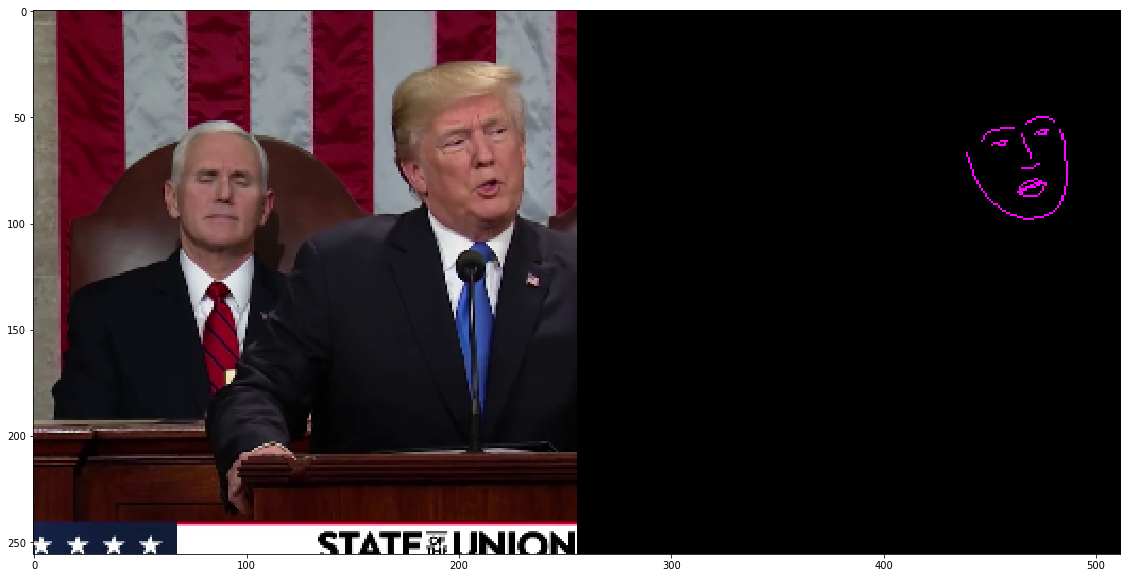

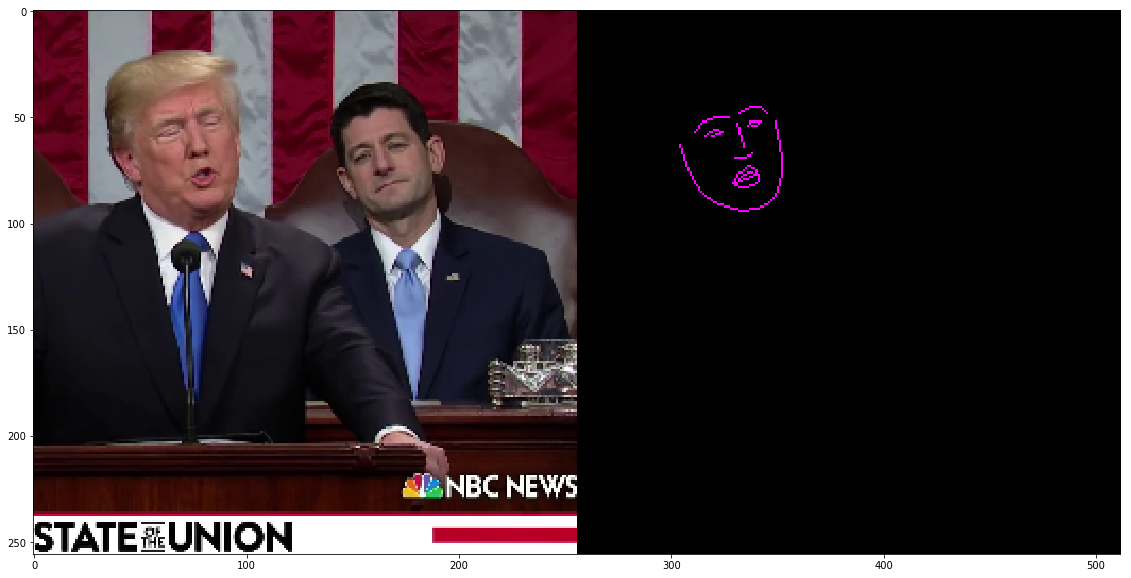

In [97]:


input_src = 'trump_sub_short.mp4'
#input_src = '../data/101_ObjectCategories/camera'
shuffle = False
max_num_images = 5


ext = os.path.splitext(input_src)[1]
is_movie = ext.lower() in ['.mp4','.mov','.avi']





def try_make_dir(new_dir):
    if not os.path.isdir(new_dir):
        os.mkdir(new_dir)


def setup_output_dirs(output_dir, save_mode, include_test):
    # split, pct_test>0         train/train_A,train_B   test/test_A,test_B
    # combined, pct_test>0      train/                  test/
    # output_only, pct_test>0   train/                  test/

    # split, pct_test=0         train_A,train_B
    # combined, pct_test=0      .
    # output_only, pct_test=0   . 

    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')

    if include_test:
        if save_mode == 'split':
            trainA_dir = os.path.join(train_dir, 'train_A')
            testA_dir = os.path.join(test_dir, 'test_A')
            trainB_dir = os.path.join(train_dir, 'train_B')
            testB_dir = os.path.join(test_dir, 'test_B')
        else:
            trainA_dir = train_dir
            testA_dir = test_dir
            trainB_dir = train_dir
            testB_dir = test_dir
    elif save_mode == 'split':
        trainA_dir = join(output_dir, 'train_A')
        trainB_dir = join(output_dir, 'train_B')
    else:
        trainA_dir = output_dir
        trainB_dir = output_dir

    try_make_dir(output_dir)   

    try_make_dir(train_dir)
    try_make_dir(trainA_dir)
    try_make_dir(trainB_dir)

    if include_test:
        try_make_dir(test_dir)
        try_make_dir(testA_dir)
        try_make_dir(testB_dir)
    
    return trainA_dir, trainB_dir, testA_dir, testB_dir


def get_frame_indexes(max_num_images, num_images, shuffle):
    num_samples = min(max_num_images if max_num_images is not None else 1e8, num_images)
    sort_order = sample(range(num_images), num_samples) if shuffle else sorted(range(num_samples))
    return sort_order


def process_image(orig_img, actions):
    img = orig_img    
    for a in actions:
        if a == 'segment':
            img = segment(img)
        elif a == 'colorize':
            colors = [[255,255,255], [0,0,0], [127,0,0], [0, 0, 127], [0, 127, 0]]
            img = quantize_colors(img, colors)
        elif a == 'trace':
            img = trace(img)
        elif a == 'hed':
            img = run_hed(img, hed_model_path)
        elif a == 'simplify':
            img = simplify(img, hed_model_path)
        elif a == 'face':
            img = extract_face(img)
        elif a == 'none' or a == '':
            pass
    return img


def reshape_for_polyline(array):
    return np.array(array, np.int32).reshape((-1, 1, 2))

DOWNSAMPLE_RATIO = 1.0

def extract_face2(img):
    global predictor
    global detector

    img = pil2cv(img)
    

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = detector(gray, 1)
    black_image = np.zeros(img.shape, np.uint8)

    faces_sorted = sorted(faces, key=lambda f:f.left()+0.5*f.width())
    face = faces_sorted[0]  #1

    detected_landmarks = predictor(gray, face).parts()
    landmarks = [[p.x * DOWNSAMPLE_RATIO, p.y * DOWNSAMPLE_RATIO] for p in detected_landmarks]

    black_image = np.zeros(img.shape, np.uint8)

    whole_face = reshape_for_polyline(landmarks[0:17] + list(reversed(landmarks[22:27])) + list(reversed(landmarks[17:22])))
    jaw = reshape_for_polyline(landmarks[0:17])
    left_eyebrow = reshape_for_polyline(landmarks[22:27])
    right_eyebrow = reshape_for_polyline(landmarks[17:22])
    nose_bridge = reshape_for_polyline(landmarks[27:31])
    lower_nose = reshape_for_polyline(landmarks[30:35])
    left_eye = reshape_for_polyline(landmarks[42:48])
    right_eye = reshape_for_polyline(landmarks[36:42])
    outer_lip = reshape_for_polyline(landmarks[48:60])
    inner_lip = reshape_for_polyline(landmarks[60:68])

    # paint
    cv2.fillPoly(black_image, [whole_face], (255, 255, 255))
    cv2.fillPoly(black_image, [left_eye], (255, 0, 0))
    cv2.fillPoly(black_image, [right_eye], (255, 0, 0))
    cv2.fillPoly(black_image, [lower_nose], (255, 255, 0))
    cv2.fillPoly(black_image, [outer_lip], (0, 0, 255))
    cv2.fillPoly(black_image, [inner_lip], (0, 255, 0))
    cv2.polylines(black_image, [left_eyebrow], False, (255, 0, 255), 4)
    cv2.polylines(black_image, [right_eyebrow], False, (255, 0, 255), 4)
    cv2.polylines(black_image, [nose_bridge], False, (0, 255, 255), 4)


    #color = (255, 255, 255)
    #thickness = 3
    #cv2.polylines(black_image, [jaw], False, color, thickness)
    #cv2.polylines(black_image, [left_eyebrow], False, color, thickness)
    #cv2.polylines(black_image, [right_eyebrow], False, color, thickness)
    #cv2.polylines(black_image, [nose_bridge], False, color, thickness)
    #cv2.polylines(black_image, [lower_nose], True, color, thickness)
    #cv2.polylines(black_image, [left_eye], True, color, thickness)
    #cv2.polylines(black_image, [right_eye], True, color, thickness)
    #cv2.polylines(black_image, [outer_lip], True, color, thickness)
    #cv2.polylines(black_image, [inner_lip], True, color, thickness)


#    black_image = black_image[y1:y2, x1:x2, :]
    

#    black_image2 = cv2.resize(black_image, (1024, 512), interpolation = cv2.INTER_LANCZOS4)
    img = black_image
    img = cv2pil(img)
    return img



def extract_face(img):
    x, y, w, h, landmarks = get_face(img)
    color, width = (255, 0, 255, 255), 1
    blank_img = Image.new('RGB', (img.width, img.height))
    img = draw_landmarks(blank_img, landmarks, color, width)
    return img


def main(): #args
    global predictor
    global detector

    face_landmark_shape_file = 'shape_predictor_68_face_landmarks.dat'
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(face_landmark_shape_file)

    os.system('rm -rf test55')

    output_dir = 'test55'#args.output_dir
    action = 'face'
    save_ext = 'png'
    save_mode = 'split' # 'combined', 'split', 'output_only'
    pct_test = 0.2
    num_per = 1
    min_w, min_h = 0, 0#512, 512
    w, h = 1024, 512


    # get list of actions
    actions = action.split(',')
    if False in [a in allowable_actions for a in actions]:
        raise Exception('one of your actions does not exist')

    # setup output directories
    trainA_dir, trainB_dir, testA_dir, testB_dir = setup_output_dirs(output_dir, save_mode, pct_test>0) 

    # initialize input 
    if is_movie:
        cap = cv2.VideoCapture(input_src)
        fps = video.FPS().start()
        num_images = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        pct_frames = list(np.linspace(0, 1, num_images))
        all_frames = get_frame_indexes(max_num_images, num_images, shuffle)

    else:
        images = [f for f in os.listdir(input_src) if os.path.isfile(os.path.join(input_src, f)) ]
        num_images = len(images)
        all_frames = get_frame_indexes(max_num_images, num_images, shuffle)

    # training/test split
    training = [1] * len(all_frames) * num_per
    if pct_test > 0:
        n_test = int(len(all_frames) * num_per * pct_test)
        test_per = 1.0 / pct_test
        test_idx = [int(test_per * (i+1) - 1) for i in range(n_test)]
        for t in test_idx:
            training[t] = 0

    # iterate through each input
    for idx_frame in tqdm(all_frames):
        
        if is_movie:
            pct_frame = pct_frames[idx_frame]
            frame = int(pct_frame * num_images)
            cap.set(1, frame);
            ret, img = cap.read()
            frame_name = 'frame%06d' % frame
            img = cv2pil(img)
        else:
            img_path = images[idx_frame]
            frame_name = os.path.splitext(img_path)[0]
            img = Image.open(os.path.join(input_src, img_path)).convert("RGB")

        # skip images which are too small
        if img.width < min_w or img.height < min_h:
            continue

        # preprocess/augment and produce input images
        imgs0, imgs1 = augmentation(img), []
        
        # process each input image to make output
        for img0 in imgs0:
            img1 = process_image(img0, actions)
            imgs1.append(img1)
        
        # save the images
        for i, (img0, img1) in enumerate(zip(imgs0, imgs1)):
            out_name = '%05d%s_%s.%s' % (idx_frame, '_%02d'%i if num_per>1 else '', frame_name, save_ext)
            print(idx_frame, i, num_per * idx_frame + i, len(training))
            is_train = training[num_per * idx_frame + i]

            if save_mode == 'combined':
                output_dir = trainA_dir if is_train else testA_dir
                img2 = Image.new('RGB', (w * 2, h))     
                img2.paste(img0.convert('RGB'), (0, 0))
                img2.paste(img1.convert('RGB'), (w, 0))
                img2.save(os.path.join(output_dir, out_name))
                
            else:
                outputA_dir = trainA_dir if is_train else testA_dir
                img0.convert('RGB').save(os.path.join(outputA_dir, out_name))
                if save_mode == 'split':
                    outputB_dir = trainB_dir if is_train else testB_dir
                    img1.convert('RGB').save(os.path.join(outputB_dir, out_name))
            
            plt.figure(figsize=(20,10))
            plt.imshow(np.concatenate([img0, img1], axis=1))


main()


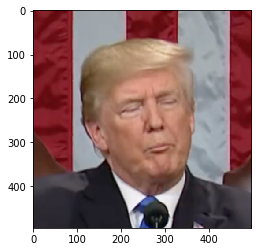

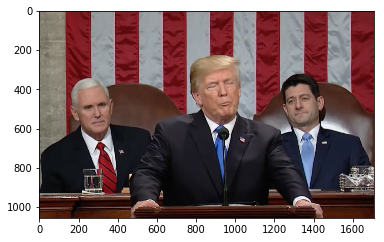

In [32]:

target_face_img = face_recognition.load_image_file('trump2.png')
target_encodings = face_recognition.face_encodings(target_face_img)[0]

plt.figure()
plt.imshow(target_face_img)
plt.figure()
plt.imshow(Image.open('trumptest.png'))

In [91]:
test_img = face_recognition.load_image_file('trumptest.png')

test_img = zzz






plt.figure(figsize=(20,10))
#plt.imshow(z4)

print([key for key in landmarks])
print(landmarks)

['right_eyebrow', 'bottom_lip', 'left_eye', 'left_eyebrow', 'chin', 'right_eye', 'nose_tip', 'nose_bridge', 'top_lip']
{'right_eyebrow': [(1356, 287), (1369, 278), (1384, 274), (1399, 277), (1411, 285)], 'bottom_lip': [(1402, 366), (1392, 369), (1383, 373), (1376, 376), (1369, 378), (1360, 382), (1348, 386), (1351, 383), (1366, 374), (1373, 372), (1380, 368), (1398, 366)], 'left_eye': [(1313, 327), (1319, 320), (1327, 317), (1337, 317), (1329, 321), (1321, 325)], 'left_eyebrow': [(1297, 323), (1300, 309), (1310, 299), (1324, 295), (1337, 295)], 'chin': [(1294, 344), (1300, 360), (1307, 375), (1313, 391), (1321, 406), (1333, 416), (1349, 422), (1368, 423), (1389, 419), (1409, 412), (1425, 403), (1440, 392), (1449, 377), (1451, 359), (1448, 339), (1444, 320), (1440, 301)], 'right_eye': [(1373, 306), (1380, 300), (1388, 298), (1397, 299), (1390, 302), (1382, 304)], 'nose_tip': [(1350, 354), (1357, 354), (1364, 353), (1371, 349), (1378, 345)], 'nose_bridge': [(1350, 305), (1353, 315), (135

<Figure size 1440x720 with 0 Axes>

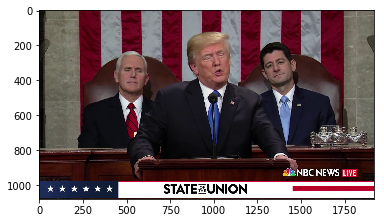